In [2]:
using AlgebraicPetri, DataFrames, DifferentialEquations, ModelingToolkit, Symbolics, EasyModelAnalysis, Catlab, Catlab.CategoricalAlgebra, JSON3, UnPack, Downloads, URIs, CSV, MathML, NLopt

In [3]:
include("demo_functions.jl")

train_test_split

1. Upload a ground-truth dataset and its documentation via a URL
    * https://github.com/reichlab/covid19-forecast-hub/blob/master/data-truth/truth-Incident%20Hospitalizations.csv
    * https://github.com/reichlab/covid19-forecast-hub/blob/master/data-truth/README.md 

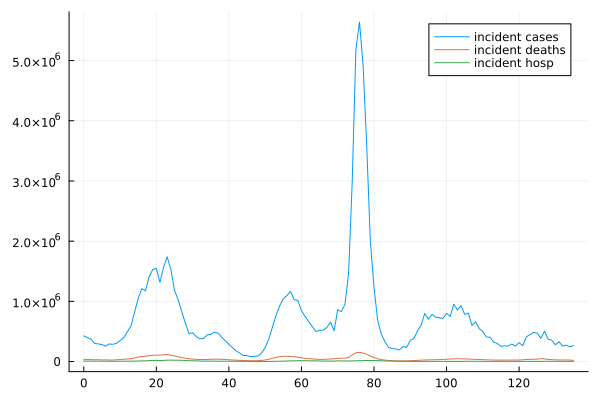

In [4]:
urls = [
    "https://github.com/reichlab/covid19-forecast-hub/raw/master/data-truth/truth-Incident%20Cases.csv",
    "https://github.com/reichlab/covid19-forecast-hub/raw/master/data-truth/truth-Incident%20Deaths.csv",
    "https://github.com/reichlab/covid19-forecast-hub/raw/master/data-truth/truth-Incident%20Hospitalizations.csv",
]

filenames = [joinpath(@__DIR__, "../data/", URIs.unescapeuri(split(url, "/")[end]))
             for url in urls]
download_covidhub_data(urls, filenames)

# Read the local CSV files into DataFrames
dfc = CSV.read(filenames[1], DataFrame)
dfd = CSV.read(filenames[2], DataFrame)
dfh = CSV.read(filenames[3], DataFrame)
covidhub = calibration_data(dfc, dfh, dfd, use_hosp = true)
df = groupby_week(covidhub)
plot_covidhub(df)

2. Split the dataset into a list of sub-datasets covering time periods of interest (in weeks)
    * select_timeperiods(df::DataFrame)::Vector{DataFrame}}


In [26]:
dfs = select_timeperiods(df, 20)

6-element Vector{DataFrame}:
 20×4 DataFrame
 Row │ t      cases    deaths  hosp  
     │ Int64  Int64    Int64   Int64 
─────┼───────────────────────────────
   1 │     0   426504   38039   7823
   2 │     1   396061   32638   7369
   3 │     2   372155   32164   7097
   4 │     3   299096   29605   6046
   5 │     4   292841   30061   6228
   6 │     5   281799   26604   5821
   7 │     6   256026   28030   5071
   8 │     7   291617   24191   5275
  ⋮  │   ⋮       ⋮       ⋮       ⋮
  14 │    13   589923   48331   6133
  15 │    14   818658   59224   7558
  16 │    15  1048060   73406   8317
  17 │    16  1212395   83419  11241
  18 │    17  1175780   88260  11034
  19 │    18  1406989   95431  16127
  20 │    19  1525551  102441  17509
                       5 rows omitted
 20×4 DataFrame
 Row │ t      cases    deaths  hosp  
     │ Int64  Int64    Int64   Int64 
─────┼───────────────────────────────
   1 │    20  1548534  105462  19039
   2 │    21  1315271  106870  16154
   3 │   

### Loading the Petri nets for our ensemble and converting them to ODESystems

In [6]:
petri_fns = [
    "BIOMD0000000955_miranet.json",
    "BIOMD0000000960_miranet.json",
    "BIOMD0000000983_miranet.json",
]

abs_fns = [joinpath(@__DIR__, "../data/", fn) for fn in petri_fns]
T_PLRN = PropertyLabelledReactionNet{Number, Number, Dict}

petris = read_json_acset.((T_PLRN,), abs_fns)
syss = structural_simplify.(ODESystem.(petris))
defs = map(x -> ModelingToolkit.defaults(x), syss)

3-element Vector{Dict{Any, Any}}:
 Dict(t5 => 0.171, zeta => 0.125, rho => 0.034, eta => 0.125, gamma => 0.456, t10 => 0.371, t16 => 0.017, Hospitalizations(t) => 0.0, Cases(t) => 0.0, Susceptible(t) => 0.9999963…)
 Dict(t5 => 0.053, ModelValue_13 => 0.053, Exposed(t) => 36600.0, ModelValue_17 => 1.64, t2 => 0.1, t3 => 0.1, ModelValue_135 => 328200000, Asymptomatic(t) => 2196.0, Infectious(t) => 732.0, beta_1_USA => 0.303…)
 Dict(t5 => 0.1, sigma => 0.2, Exposed(t) => 112.0, Quarantined(t) => 36.0, t2 => 0.1, t3 => 0.1, Susceptible_unconfined(t) => 6.699e7, q => 0.83, t7 => 0.1, t8 => 0.1…)

### Adjust all model defaults to be standardized to population, not proportion of population, then convert to simulatable ODEProblems

In [7]:
total_pop = 300_000_000
N_weeks = 10

# adjust the defaults to be in terms of the total population. now all 3 models have defaults in terms of pop
# this is a weak link in the workflow
# scale the outputs for loss instead of the u0
for i in 1:2 # only the first two are in proportions 
    for st in states(syss[i])
        defs[i][st] *= total_pop # this mutates the return of ModelingToolkit.defaults
    end
end

In [19]:
observed.(syss)

3-element Vector{Vector{Equation}}:
 [Deaths(t) ~ Extinct(t), Hospitalizations(t) ~ Recognized(t) + Threatened(t), Cases(t) ~ Diagnosed(t) + Hospitalizations(t)]
 [Cases(t) ~ Infectious(t), Hospitalizations(t) ~ Hospitalized(t), Deaths(t) ~ Deceased(t)]
 [Cases(t) ~ Infected_reported(t), Deaths(t) ~ Deceased(t), Hospitalizations(t) ~ h*Infected_reported(t)]

3. Generate model-model and model-dataset alignment/map during structural comparisons
    * e.g. {("model0.S", "model1.s", ...):  "dataset.feature0", ...} 
    * V{Tuple{V{State/Obs}, Symbol}}. Hosp, cases, 


Since the MiraNet schema encodes the observables (Cases, Deaths, Hospitalizations) uniformly through all models in the ensemble, we only need to provide a single list of Model observable => column name

In [20]:
@unpack Deaths, Hospitalizations, Cases = syss[1]
mapping = Dict([Deaths => :deaths, Cases => :cases, Hospitalizations => :hosp])

Dict{Num, Symbol} with 3 entries:
  Deaths(t)           => :deaths
  Hospitalizations(t) => :hosp
  Cases(t)            => :cases

4. Build an ensemble model using a list of the above models and alignment/map.
    * build_ensemble_model(Tuple{Vector<ODESystem>, typeof(3)})::EnsembleProblem | Vector{ODEProblem}


In [9]:
probs = map(x -> ODEProblem(x, [], (0, 100)), syss);

5. Build and run an ensemble calibration simulator 
    * Select the list of split ground-truth sub-datasets as training-test datasets
    * Select the ensemble model as the input model
    * Select the alignment/map
    * Specify the ensemble calibration mode (no-training-equal-weights, separate-model-weight training, joint model-weight training)
    * Specify the train-validate-test ratio, cross-validation mode, loss function, early-stop condition, etc.
    * ensemble_calibrate_separate(typeof(4), typeof(2)[1][1]; optimization_options)::V<(calibrationmap,loss,weights)>
    * Total 1-4. train 1-2, test 3-4. Trainloss = l2(1-2), testloss = l2(3-4)  


In [10]:
split_dfs = [train_test_split(df; train_weeks=5) for df in dfs]
dfi = dfs[1]
dfx, dfy = split_dfs[1]

(5×4 DataFrame
 Row │ t      cases   deaths  hosp  
     │ Int64  Int64   Int64   Int64 
─────┼──────────────────────────────
   1 │     0  426504   38039   7823
   2 │     1  396061   32638   7369
   3 │     2  372155   32164   7097
   4 │     3  299096   29605   6046
   5 │     4  292841   30061   6228, 5×4 DataFrame
 Row │ t      cases   deaths  hosp  
     │ Int64  Int64   Int64   Int64 
─────┼──────────────────────────────
   1 │     5  281799   26604   5821
   2 │     6  256026   28030   5071
   3 │     7  291617   24191   5275
   4 │     8  286018   25358   5347
   5 │     9  300436   28491   4953)

In [11]:
ensemble_res = [calibrate(prob, dfx, mapping) for prob in probs]

┌ Info: (5.696302916060577e16, 1)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (5.767590079874413e16, 2)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (5.696302916060577e16, 3)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (5.6235234788516344e16, 4)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (5.598932690506863e16, 5)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (5.598932690506863e16, 6)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (5.598932690506863e16, 7)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (5.598932690506863e16, 8)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (5.647940297889951e16, 9)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_function

┌ Info: (2.7332007250941576e16, 89)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (2.7327185218838264e16, 90)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (2.732468199618105e16, 91)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (2.732165181044157e16, 92)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (2.7320188886246724e16, 93)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (2.7318613155906212e16, 94)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (2.7317619481589052e16, 95)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (2.73165778844179e16, 96)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (2.7316147759746196e16, 97)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/

┌ Info: (2.7313846024534256e16, 141)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (2.7313845944756696e16, 142)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (2.73138459690662e16, 143)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (2.731384594137956e16, 144)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (2.731384597233145e16, 145)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (2.7313845950746464e16, 146)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (2.7313845956136332e16, 147)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (2.731384595861477e16, 148)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (2.731384594991325e16, 149)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysi

┌ Info: (6.539159322173561e11, 229)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.533532690321438e11, 230)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.520551709646924e11, 231)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.505851215586367e11, 232)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.481898220049417e11, 233)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.463378765946543e11, 234)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.425667226707256e11, 235)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.38731881787528e11, 236)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.321258994060793e11, 237)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/te

┌ Info: (4.6947314543925995e10, 265)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (4.6966789012213974e10, 266)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (4.7382062513451385e10, 267)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (4.6931481871444695e10, 268)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (4.6943025587006836e10, 269)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (4.7051039958053276e10, 270)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (4.692622081090506e10, 271)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (4.693173935860529e10, 272)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (4.692638625780328e10, 273)
└ @ Main /Users/anand/.julia/dev/EasyModelAnal

┌ Info: (2.6203095611517967e10, 341)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (2.6201095425063667e10, 342)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (2.6201227559511604e10, 343)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (2.6200676270875343e10, 344)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (2.620239621333059e10, 345)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (2.6200570308444855e10, 346)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (2.6200601664004967e10, 347)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (2.62009380673211e10, 348)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (2.6200572921934464e10, 349)
└ @ Main /Users/anand/.julia/dev/EasyModelAnal

┌ Info: (2.091896869457063e10, 429)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (2.091896869457063e10, 430)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (2.0918968682757042e10, 431)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (2.0918968725035126e10, 432)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (2.091896869145797e10, 433)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (2.0918968692481483e10, 434)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (2.091896867473744e10, 435)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (2.091896867473744e10, 436)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (2.091896869145797e10, 437)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysi

┌ Info: (1.776904223385524e10, 489)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (1.6937081401851206e10, 490)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (1.6937081401851206e10, 491)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (1.719663628945543e10, 492)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (1.6907968301466137e10, 493)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (1.6907968301466137e10, 494)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (1.6945964556835995e10, 495)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (1.6914136145689842e10, 496)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (1.6918577751898373e10, 497)
└ @ Main /Users/anand/.julia/dev/EasyModelAna

┌ Info: (1.6907821295190628e10, 541)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (1.6907821295190628e10, 542)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (1.6907821295190628e10, 543)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (1.6907821295190628e10, 544)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (1.6907821295190628e10, 545)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (1.6907821195024452e10, 546)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (1.690782445926401e10, 547)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (1.6907818036343933e10, 548)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (1.6907817061298489e10, 549)
└ @ Main /Users/anand/.julia/dev/EasyModelAn

┌ Info: (1.6901028919658417e10, 629)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (1.6898610777078238e10, 630)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (1.6899340247389477e10, 631)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (1.689412231432338e10, 632)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (1.6889498324337015e10, 633)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (1.6889059435347132e10, 634)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (1.6884631881190018e10, 635)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (1.6875139295824738e10, 636)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (1.6863872285448582e10, 637)
└ @ Main /Users/anand/.julia/dev/EasyModelAn

┌ Info: (1.6689398292861296e10, 691)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (1.6689398741442865e10, 692)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (1.668939748601057e10, 693)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (1.6691361530942818e10, 694)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (3.688597895499875e10, 695)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (8.347946695917699e9, 696)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (1.0823697436748125e10, 697)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (8.348758429250038e9, 698)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (1.0824690161578615e10, 699)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysi

┌ Info: (8.271524292311203e9, 779)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (8.270285751410307e9, 780)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (8.270285751410307e9, 781)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (8.269297562155687e9, 782)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (8.268661594624887e9, 783)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (8.268661594624887e9, 784)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (8.267933798783143e9, 785)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (8.267716788341892e9, 786)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (8.267716788341892e9, 787)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_

┌ Info: (8.053483502057293e9, 825)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (8.05358843852808e9, 826)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (8.053489056187452e9, 827)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (8.0537265278735485e9, 828)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (8.053488400338414e9, 829)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (8.053483502057293e9, 830)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (8.053483502057293e9, 831)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (8.053483502057293e9, 832)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (8.053483502057293e9, 833)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_

┌ Info: (7.874100508822993e9, 913)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (7.890184906031996e9, 914)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (7.872128403850321e9, 915)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (7.872507577242129e9, 916)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (7.8754051206431265e9, 917)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (7.872373477694062e9, 918)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (7.872507982194118e9, 919)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (7.872249263551106e9, 920)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (7.872701966676987e9, 921)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo

┌ Info: (7.8625008846000595e9, 953)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (7.862665240560566e9, 954)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (7.86249936502331e9, 955)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (7.862515035918237e9, 956)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (7.862498688590154e9, 957)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (7.862517113074299e9, 958)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (7.862494505365125e9, 959)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (7.862518873732398e9, 960)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (7.862494327786944e9, 961)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_

┌ Info: (2.614142766024991e29, 1)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (2.614142766024991e29, 2)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (2.614142766024991e29, 3)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (2.614142766024991e29, 4)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (2.614142766024991e29, 5)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (2.614142766024991e29, 6)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (2.614142766024991e29, 7)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (2.614142766024991e29, 8)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (2.614142766024991e29, 9)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions

┌ Info: (6.58051648465e11, 89)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (2.5919667472635324e29, 90)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.58051648465e11, 91)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.58051648465e11, 92)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.58051648465e11, 93)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.58051648465e11, 94)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.58051648465e11, 95)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.58051648465e11, 96)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.58051648465e11, 97)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.580

┌ Info: (6.58051648465e11, 133)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.58051648465e11, 134)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.58051648465e11, 135)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.58051648465e11, 136)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.58051648465e11, 137)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.58051648465e11, 138)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.58051648465e11, 139)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.58051648465e11, 140)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.58051648465e11, 141)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6

┌ Info: (6.568828793540132e11, 223)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.566221624915802e11, 224)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.561645613671948e11, 225)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.557718229854199e11, 226)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.551106703312993e11, 227)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.545772334512351e11, 228)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.537749769103488e11, 229)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.532460546348517e11, 230)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527828910974098e11, 231)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/t

┌ Info: (6.527699434554998e11, 311)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434554998e11, 312)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434554998e11, 313)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434554998e11, 314)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434554998e11, 315)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434554998e11, 316)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434554998e11, 317)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434554998e11, 318)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189


┌ Info: (6.527699434554998e11, 319)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434554998e11, 320)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434554998e11, 321)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434554998e11, 322)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434554998e11, 323)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434554998e11, 324)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434554998e11, 325)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434554998e11, 326)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434554998e11, 327)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/t

┌ Info: (6.527699434552e11, 395)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434552e11, 396)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434552e11, 397)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434552e11, 398)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434552e11, 399)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434552e11, 400)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434552e11, 401)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434552e11, 402)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434552e11, 403)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌

┌ Info: (6.527699434552e11, 485)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434552e11, 486)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434552e11, 487)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434552e11, 488)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434552e11, 489)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434552e11, 490)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434552e11, 491)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434552e11, 492)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434552e11, 493)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌

┌ Info: (6.527699434552e11, 575)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434552e11, 576)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434552e11, 577)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434552e11, 578)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434552e11, 579)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434552e11, 580)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434552e11, 581)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434552e11, 582)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434552e11, 583)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌

┌ Info: (6.527699434552e11, 593)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434552e11, 594)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434552e11, 595)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434552e11, 596)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434552e11, 597)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434552e11, 598)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434552e11, 599)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434552e11, 600)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434552e11, 601)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌

┌ Info: (6.527699434552e11, 683)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434552e11, 684)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434552e11, 685)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434552e11, 686)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434552e11, 687)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434552e11, 688)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434552e11, 689)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434552e11, 690)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434552e11, 691)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌

┌ Info: (6.527699434552e11, 711)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434552e11, 712)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434552e11, 713)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434552e11, 714)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434552e11, 715)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434552e11, 716)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434552e11, 717)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434552e11, 718)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434552e11, 719)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌

┌ Info: (6.527699434552e11, 801)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434552e11, 802)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434552e11, 803)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434552e11, 804)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434552e11, 805)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434552e11, 806)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434552e11, 807)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434552e11, 808)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434552e11, 809)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌

┌ Info: (4.1316157651759e29, 885)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (4.131574819659554e29, 886)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434552e11, 887)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434552e11, 888)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434552e11, 889)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434552e11, 890)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434552e11, 891)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434552e11, 892)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434552e11, 893)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:1

┌ Info: (6.527699434552e11, 975)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434552e11, 976)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434552e11, 977)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434552e11, 978)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434552e11, 979)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434552e11, 980)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434552e11, 981)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434552e11, 982)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527699434552e11, 983)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌

┌ Info: (4.3179151313172806e14, 1)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (4.3179142754654825e14, 2)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (4.3179142754654825e14, 3)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (4.317914258047386e14, 4)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (4.317914254043986e14, 5)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (4.317914254043986e14, 6)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (4.317914251469541e14, 7)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (4.3179142506900306e14, 8)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (4.3179142506900306e14, 9)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_func

┌ Info: (3.6972113402595975e14, 89)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (3.6972097554082644e14, 90)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (3.697248730980087e14, 91)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (3.697212333537651e14, 92)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (3.6971693029861756e14, 93)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (3.6972316581558056e14, 94)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (3.6972436069583006e14, 95)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (3.697158020330181e14, 96)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (3.697256684751155e14, 97)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/

┌ Info: (3.69715654053507e14, 99)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (3.697184934761702e14, 100)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (3.6972424504363194e14, 101)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (3.6972230217102844e14, 102)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (3.697229252891273e14, 103)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (3.6971612462361956e14, 104)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (3.6972513130857875e14, 105)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (3.697230042957234e14, 106)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (3.6972646283704644e14, 107)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysi

┌ Info: (3.697150347341128e14, 125)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (3.69714898431212e14, 126)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (3.697149474445818e14, 127)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (3.697148995383247e14, 128)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (3.6971491154513506e14, 129)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (3.697148951092322e14, 130)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (3.697149012641891e14, 131)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (3.697148953668909e14, 132)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (3.697148968139476e14, 133)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/t

┌ Info: (6.580031072134904e11, 213)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.580031072134904e11, 214)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.580031072134904e11, 215)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.580031072134904e11, 216)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.58003107407237e11, 217)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.580030178586785e11, 218)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.580030178575862e11, 219)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.580029780767853e11, 220)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.580029070204733e11, 221)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/te

┌ Info: (6.580021822622411e11, 259)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.580021823142323e11, 260)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.580021824518754e11, 261)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.580021824784065e11, 262)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.580021821526525e11, 263)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.580021824386589e11, 264)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.580021821522261e11, 265)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.580021824312256e11, 266)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.580021821824795e11, 267)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/t

┌ Info: (6.567550949302734e11, 347)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.567550949302734e11, 348)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.561943033782734e11, 349)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.556754548662734e11, 350)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.556754548662734e11, 351)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.547635869622734e11, 352)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.540194912182734e11, 353)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.540194912182734e11, 354)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.530346162102734e11, 355)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/t

┌ Info: (6.527204771542734e11, 385)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527204772822734e11, 386)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527204771262734e11, 387)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527204771262734e11, 388)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527204771542734e11, 389)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527204771272734e11, 390)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527204771352734e11, 391)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527204771255234e11, 392)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.527204771255234e11, 393)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/t

┌ Info: (6.524880192978236e11, 473)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.524880192978451e11, 474)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.524880192977072e11, 475)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.524880192977367e11, 476)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.524880192976725e11, 477)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.524880191214093e11, 478)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.524880191214093e11, 479)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.524880193529203e11, 480)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.524880187779136e11, 481)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/t

┌ Info: (6.524880185761713e11, 531)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.524880185761958e11, 532)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.524880185761692e11, 533)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.524880185762048e11, 534)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.52488018576167e11, 535)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.524880185762068e11, 536)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.524880185761722e11, 537)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.524880185761722e11, 538)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.524880185761532e11, 539)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/te

┌ Info: (6.524799287324033e11, 619)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.524799284924562e11, 620)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.52479928238567e11, 621)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.524799277051636e11, 622)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.524799272435e11, 623)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.52479927728729e11, 624)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.524799277310923e11, 625)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.524799273081931e11, 626)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.524799277424539e11, 627)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/d

┌ Info: (6.524799272045198e11, 649)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.524799272047169e11, 650)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.52479927204232e11, 651)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.524799272047317e11, 652)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.524799272041162e11, 653)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.524799272044213e11, 654)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.524799272039779e11, 655)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.524799272043481e11, 656)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.524799272039174e11, 657)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/te

┌ Info: (6.524782472778029e11, 737)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.524782472778029e11, 738)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.524782472778029e11, 739)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.524782472778029e11, 740)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.524782472778029e11, 741)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.524782472778029e11, 742)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.524782472778029e11, 743)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.524782472778029e11, 744)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.524782472778029e11, 745)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/t

┌ Info: (6.524772899860415e11, 797)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.524772841415774e11, 798)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.524772809682523e11, 799)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.524772774496084e11, 800)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.52477275518828e11, 801)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.524772734111128e11, 802)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.524772722685565e11, 803)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.524772710119761e11, 804)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.524772703268978e11, 805)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/te

┌ Info: (6.524772674866453e11, 885)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.524772674866453e11, 886)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.524772674866453e11, 887)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.524772674866453e11, 888)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.524772674866453e11, 889)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.524772674866453e11, 890)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.524772674866453e11, 891)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.524772674866453e11, 892)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.524772674866453e11, 893)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/t

┌ Info: (6.524772674866453e11, 931)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.524772674866453e11, 932)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.524772674866453e11, 933)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.524772674866453e11, 934)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.524772674866453e11, 935)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.524772674866453e11, 936)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.524772674866453e11, 937)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.524772674866453e11, 938)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo_functions.jl:189
┌ Info: (6.524772674866453e11, 939)
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/t

3-element Vector{SciMLBase.OptimizationSolution{Float64, 1, Vector{Float64}, C, Algorithm, Float64, Opt, Float64, Nothing} where C<:SciMLBase.AbstractOptimizationCache}:
 retcode: MaxIters
u: [0.20306250000000003, 0.26416015625, 0.0371875, 0.13671875, 0.03562499999999999, 0.0, 1228.305342910734, 64641.754136321266, 0.0, 0.0  …  1.2195839843749998, 0.00790625, 0.25, 0.040000000000000015, 0.78125, 11.69140625, 45521.91379646553, 0.01203125, 0.029531250000000002, 0.0]
Final objective value:     7.859769768555887e9

 retcode: MaxIters
u: [0.06430774274476746, 0.06430774274476746, 0.0, 3.3543110960036255, 0.050246667580627444, 0.27616934804437265, 5.7508285322394185e6, 0.0, 0.0, 0.6234167150188792  …  0.0, 0.14551749016249482, 0.11078116439046498, 0.06366277176610137, 0.0276272405777421, 4.911288725262373, 0.06606514051199197, 0.11076230084249794, 0.14551749016249482, 0.00035187255464118046]
Final objective value:     6.527699434552e11

 retcode: MaxIters
u: [0.0, 1.0968885591919735, 0.0, 1

In [21]:
map(x->x.u, ensemble_res)

3-element Vector{Vector{Float64}}:
 [0.171, 0.29552089615132926, 0.04571762125316156, 0.15239911995066463, 0.09282698958002462, 0.0, 1228.5399572181936, 64647.93435616243, 21421.64332588081, 0.0  …  0.0938313337847772, 0.004210937499999998, 1.6708009563162936, 0.002035679596053172, 0.0, 106.39978618662575, 176667.78880572354, 0.013411122555658489, 0.03291820990934356, 0.0]
 [0.06440803880501747, 0.06442803415611088, 0.0, 3.35679587236186, 0.049754408039503054, 0.27639631297143574, 2.0962239799921837e7, 0.0, 0.0, 0.6238757926022698  …  0.0, 0.149809291141492, 0.11093267514401585, 0.06442803415611088, 0.02767076528312365, 4.936075897373096, 0.06616922132920872, 0.11097040222155061, 0.149809291141492, 0.000348892257917646]
 [3.4898026729279383, 1.0938964267152769, 180244.49680747304, 7.927713617499692, 714.325459485188, 0.0, 6.2803125e6, 1.738420170868399, 0.2419187768305534, 0.22216796875  …  0.005505356678819231, 8.290384985933997, 0.0, 0.10487988550787278, 0.0, 0.08461543381837983, 495

### The next cell indicates that the third model is the best fit using `norm` as the score function

In [12]:
new_probs = [remake(prob, u0 = res.u, p = res.u) for (prob, res) in zip(probs, ensemble_res)]

# push!(calibrated_probs, new_probs)
train_scores = EasyModelAnalysis.model_forecast_score(new_probs, dfx.t, to_data(dfx, mapping))
test_scores = EasyModelAnalysis.model_forecast_score(new_probs, dfy.t, to_data(dfy, mapping))
@info "Train scores: $(train_scores)"
@info "Test scores: $(test_scores)"

┌ Info: Train scores: [894915.5417873069, 1.3609869837899586e7, 896269.1329106729]
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo.ipynb:6
┌ Info: Test scores: [732884.3662110387, 1.3445861821946917e7, 705384.9243969718]
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo.ipynb:7


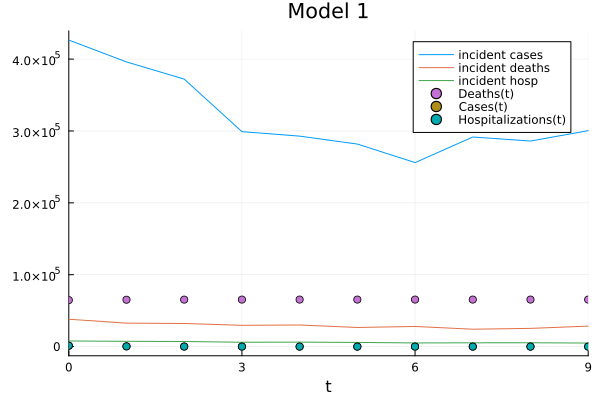

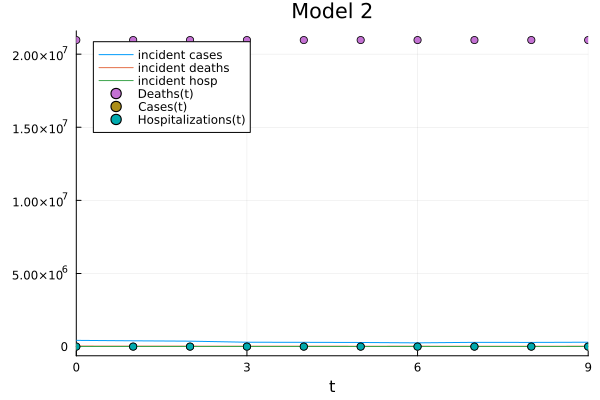

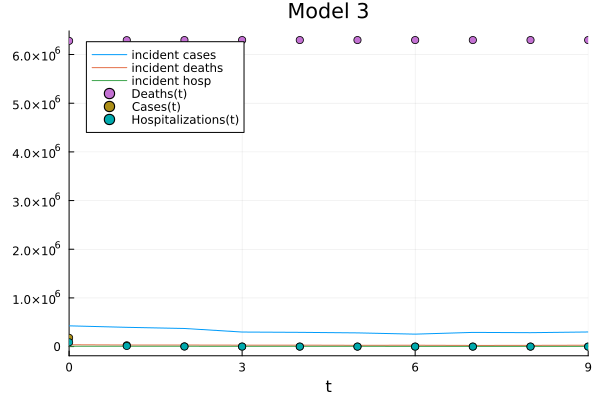

In [17]:
ts = dfi.t
for (i, prob) in enumerate(new_probs)
    sol = solve(prob; saveat = ts)
    plt = plot_covidhub(dfi)

    # todo change the color of the forecasted points to be distinct from data used to calibrate
    scatter!(plt, sol, idxs = [Deaths, Cases, Hospitalizations];title="Model $(i)")
    display(plt)
end

6. Assess consistency of the ensemble by tracking the smoothness/continuity of the ensemble weights across the time periods of interest. (plots from page 1, and bar plot)

In [28]:
# still todo is the weighted sums for the ensemble and smoothness 
# scoring/weightings over time plot
# visualize the optimization results (specifically parameters)
# length of stay- data correction 
# start with single model workflow 
# still need to fix the rates 

# parse the distributions 
[ModelingToolkit.equations(syss[1]); observed(syss[1])]

11-element Vector{Equation}:
 Differential(t)(Susceptible(t)) ~ -t1*Diagnosed(t)*Susceptible(t) - t2*Ailing(t)*Susceptible(t) - t4*Infected(t)*Susceptible(t) - t3*Recognized(t)*Susceptible(t)
 Differential(t)(Infected(t)) ~ t1*Diagnosed(t)*Susceptible(t) + t2*Ailing(t)*Susceptible(t) + t4*Infected(t)*Susceptible(t) + t3*Recognized(t)*Susceptible(t) - t5*Infected(t) - t6*Infected(t) - t7*Infected(t)
 Differential(t)(Diagnosed(t)) ~ t5*Infected(t) - t8*Diagnosed(t) - t9*Diagnosed(t)
 Differential(t)(Ailing(t)) ~ t6*Infected(t) - t10*Ailing(t) - t11*Ailing(t) - t12*Ailing(t)
 Differential(t)(Recognized(t)) ~ t10*Ailing(t) + t8*Diagnosed(t) - t13*Recognized(t) - t14*Recognized(t)
 Differential(t)(Healed(t)) ~ t11*Ailing(t) + t7*Infected(t) + t14*Recognized(t) + t16*Threatened(t) + t9*Diagnosed(t)
 Differential(t)(Threatened(t)) ~ t12*Ailing(t) + t13*Recognized(t) - t15*Threatened(t) - t16*Threatened(t)
 Differential(t)(Extinct(t)) ~ t15*Threatened(t)
 Deaths(t) ~ Extinct(t)
 Hospitalizatio

7. Build and run a forecast simulator
    * Select the alignment/map from 
    * Select the ensemble model from 
    * Select the calibrated parameter output from 
    * Select the time points of the forecast horizon 
    * forecast(calibrated 4, df), forecast(4, df, calibrationmap)
    * ensemble_forecast(4, df, map, weights)


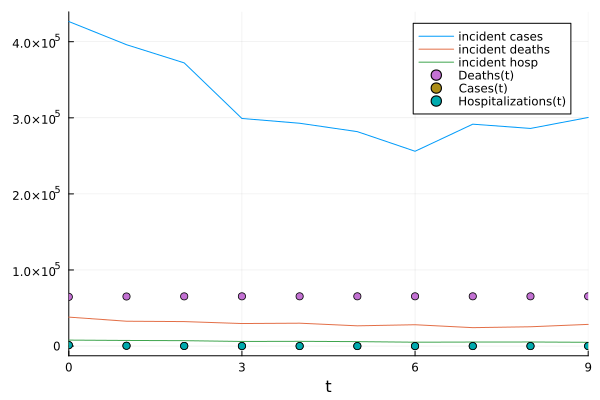

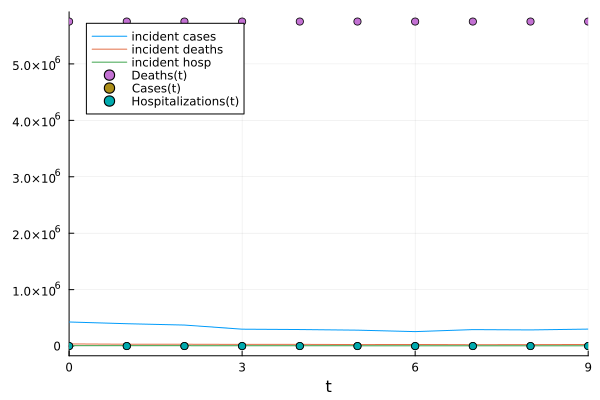

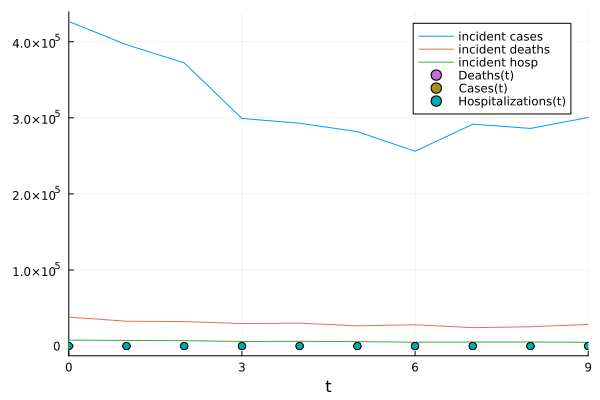

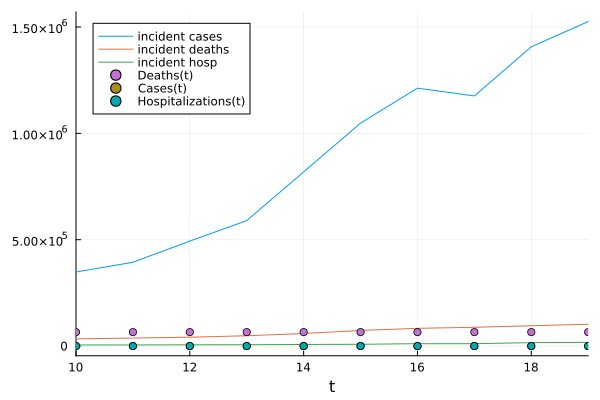

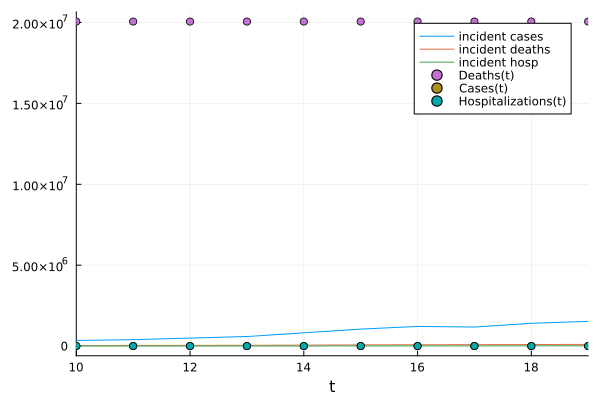

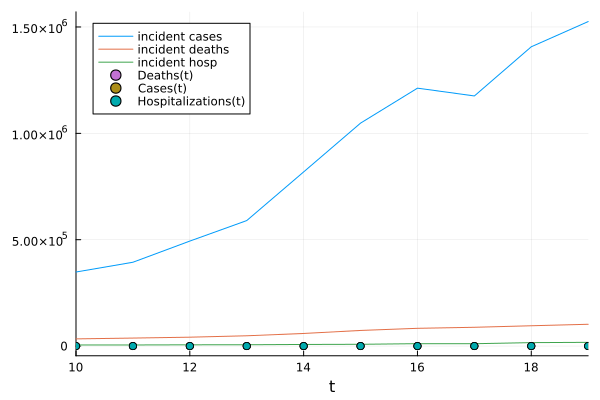

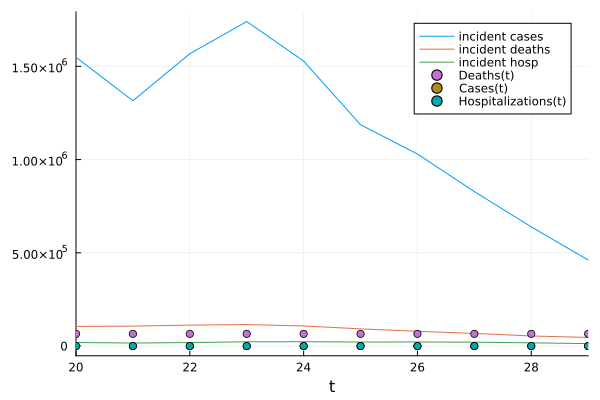

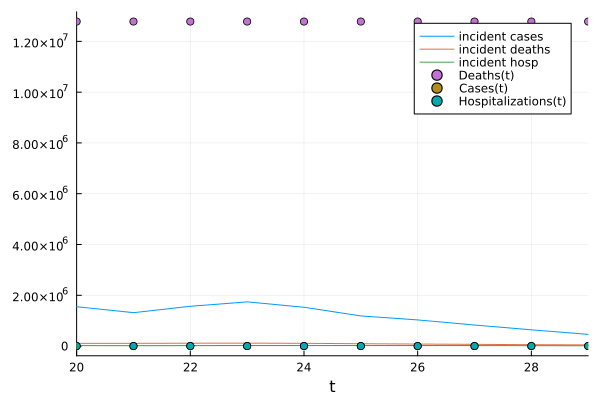

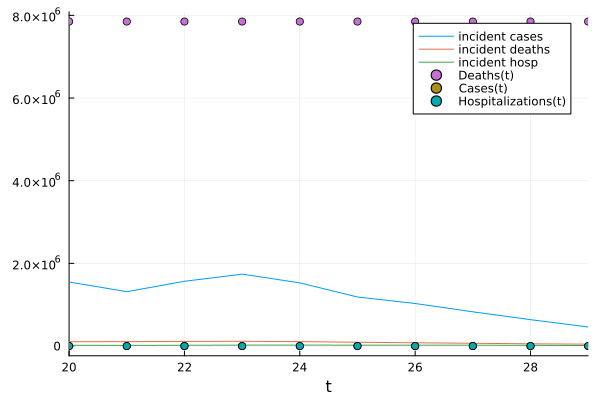

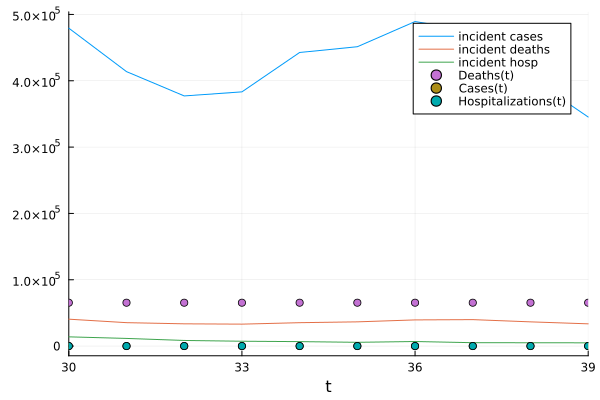

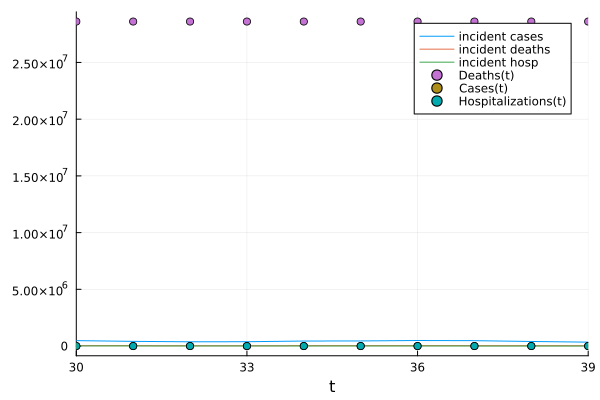

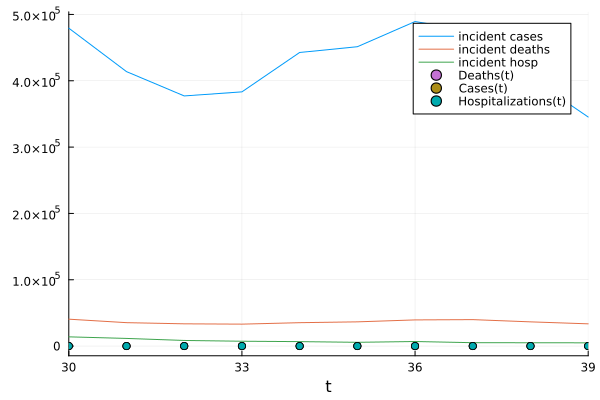

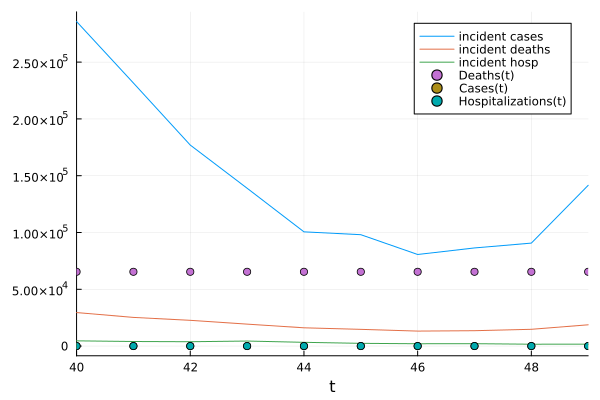

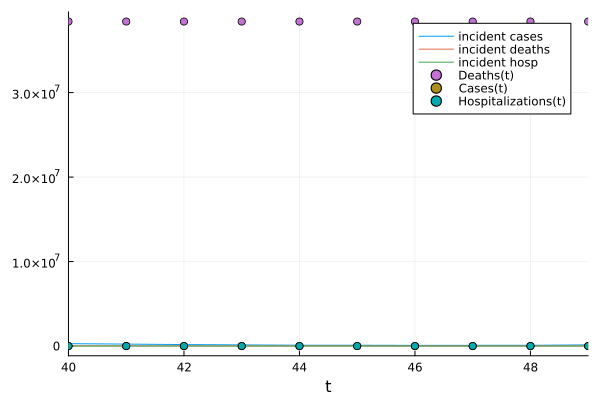

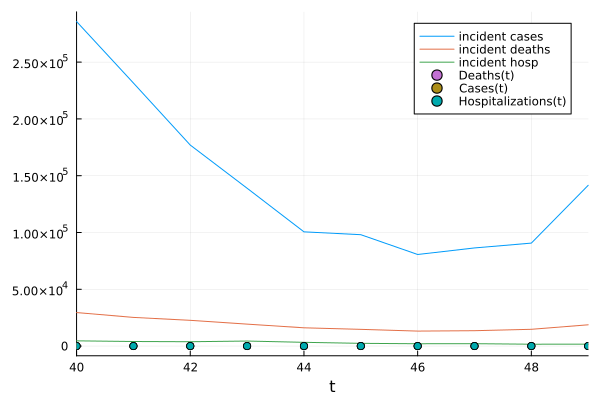

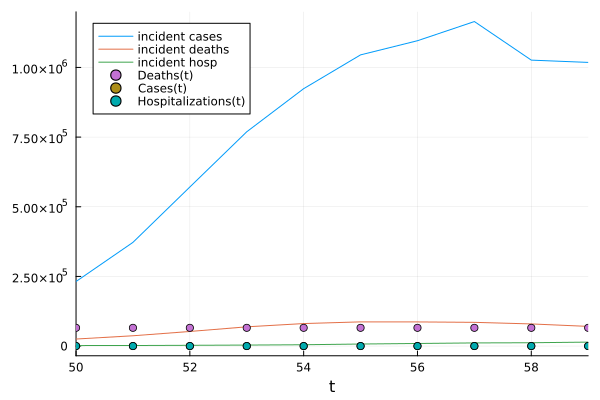

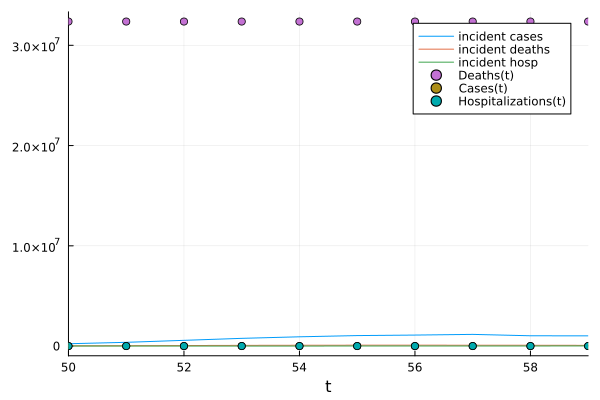

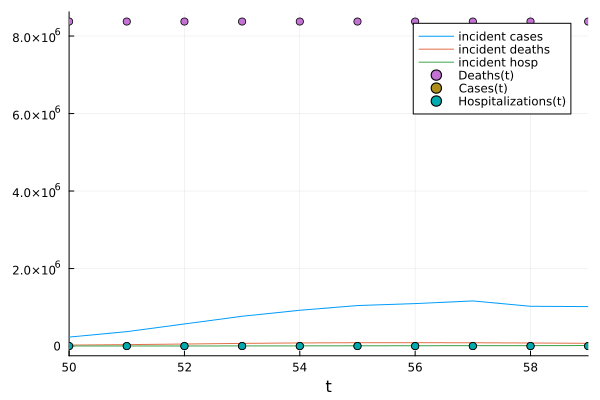

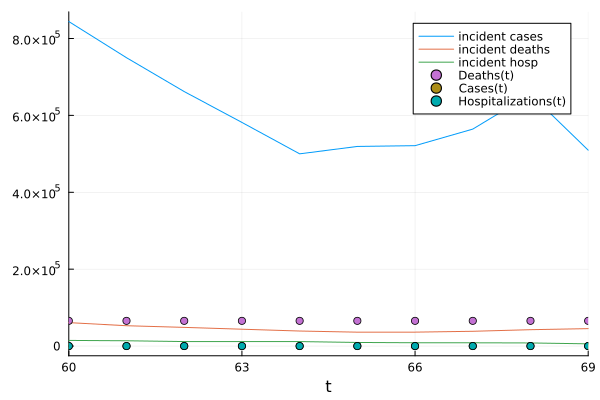

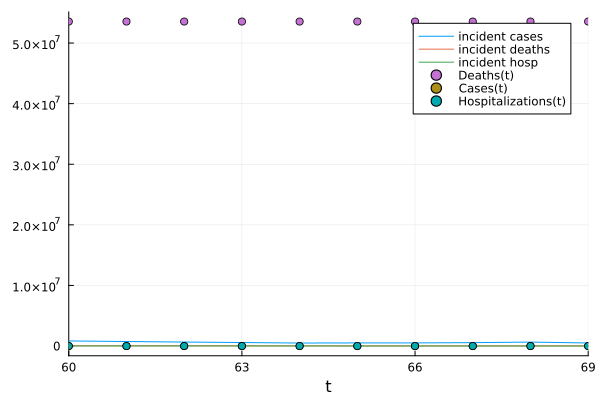

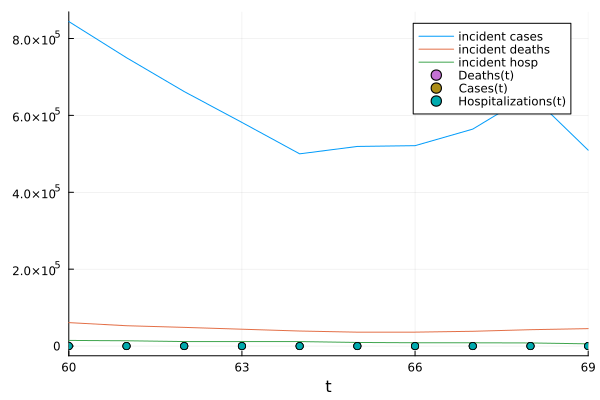

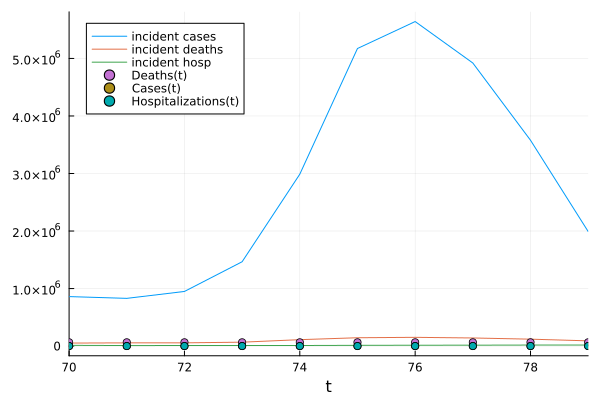

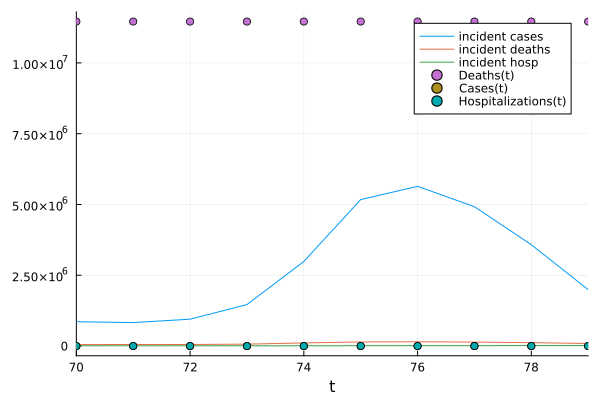

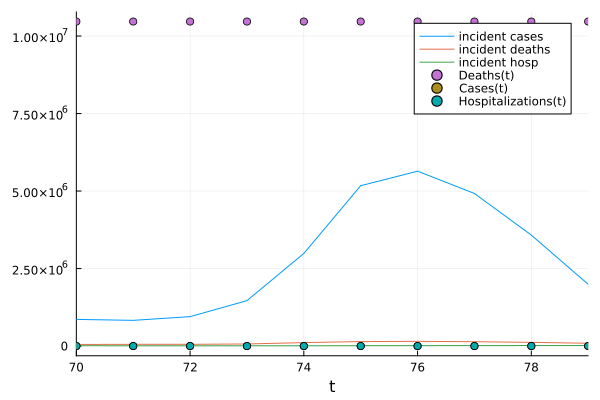

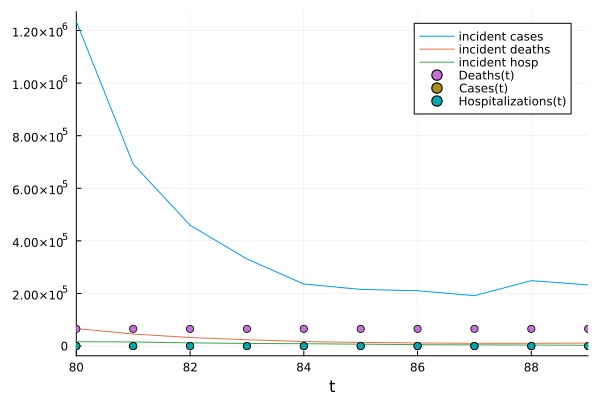

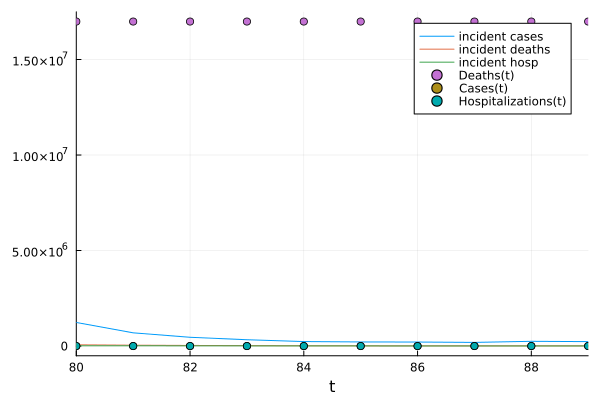

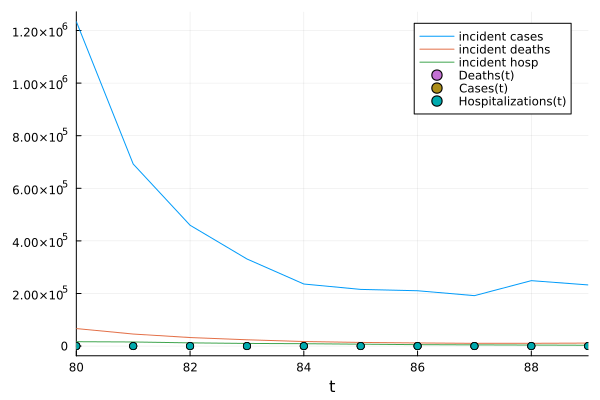

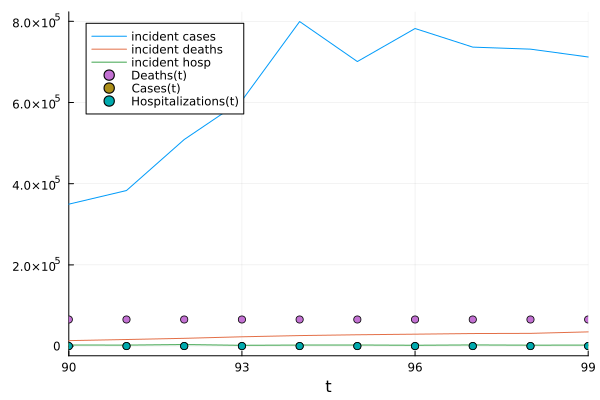

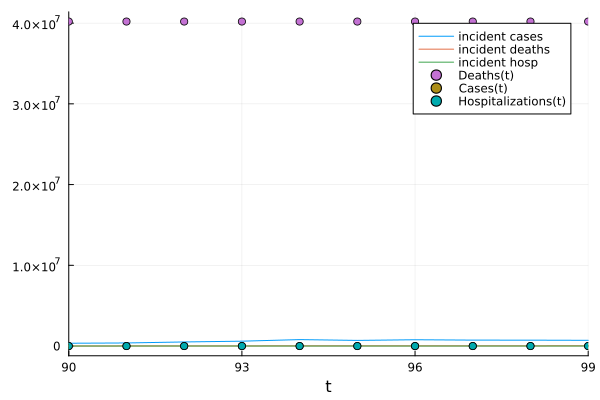

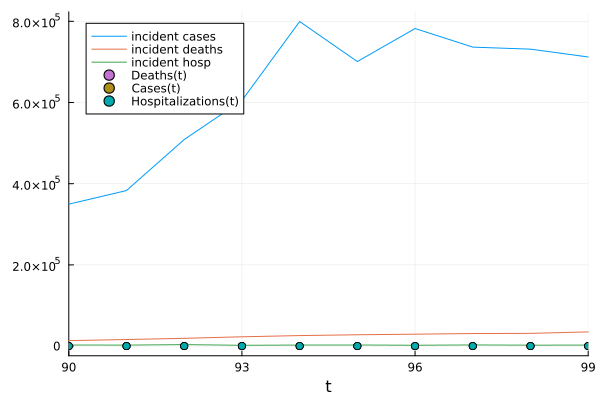

DimensionMismatch: DimensionMismatch: dimensions must match: a has dims (Base.OneTo(1),), b has dims (Base.OneTo(5),), mismatch at 1

In [18]:
for dfi in dfs[1:(end-1)] # cut the end since the length of train test isnt the same
    @info "" dfi
    dfx, dfy = train_test_split(dfi; train_weeks=N_weeks÷2)
    
    xdata = to_data(dfx, mapping)
    ydata = to_data(dfy, mapping)

    ensemble_res = [calibrate(prob, dfx, mapping) for prob in probs]
    push!(ress, ensemble_res)

    new_probs = [remake(prob, u0=res.u, p=res.u)
                 for (prob, res) in zip(probs, ensemble_res)]

    push!(calibrated_probs, new_probs)
    try
        push!(xscores, EasyModelAnalysis.model_forecast_score(new_probs, dfx.t, xdata))
        push!(yscores, EasyModelAnalysis.model_forecast_score(new_probs, dfy.t, ydata))
    catch e
        break
    end
    ts = dfi.t
    data = to_data(dfi, mapping)
    sols = []
    for prob in new_probs
        sol = solve(prob; saveat=ts)
        push!(sols, sol)
        plt = plot_covidhub(dfi)
        # todo change the color of the forecasted points
        scatter!(plt, sol, idxs=[Deaths, Cases, Hospitalizations])
        display(plt)
    end
    push!(all_sols, sols)
end

10-element Vector{Vector{Int64}}:
 [3, 1, 2]
 [1, 3, 2]
 [1, 3, 2]
 [1, 3, 2]
 [3, 1, 2]
 [1, 3, 2]
 [1, 3, 2]
 [1, 3, 2]
 [3, 1, 2]
 [3, 1, 2]

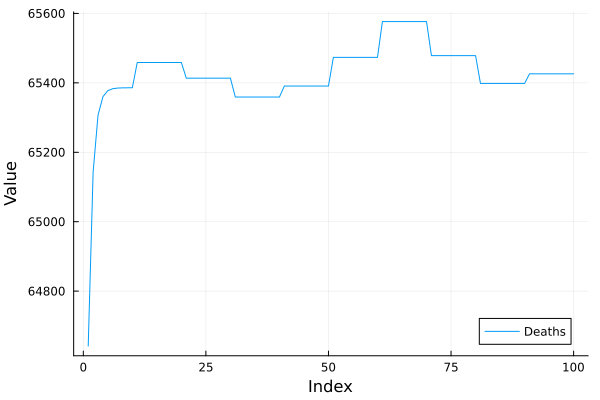

In [25]:
data = hcat(mapreduce(x -> x[[Deaths, Hospitalizations, Cases]], vcat, first.(all_sols))...)

p = plot(data[1, :], label="Deaths", xlabel="Index", ylabel="Value")
plot(df.t[1:100], data[1, :], label="Deaths")
plot(df.t[1:100], data[2, :], label="Cases")
plot(df.t[1:100], data[3, :], label="Hospitalizations")
plot!(data[ 3, :], label="Cases")

display(p)
